In [1]:
import warnings
warnings.filterwarnings('ignore')

# Importing necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

# Ensure inline plotting
%matplotlib inline

# If matplotlib is imported, ensure the right backend is used
matplotlib.use('Agg')

# Additional imports for modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler

print('Libraries imported successfully.')
file_path = "university_mental_health_iot_dataset.csv"
df = pd.read_csv(file_path, encoding='ascii', delimiter=',')

# Convert the 'timestamp' column to datetime since it represents date information
df['timestamp'] = pd.to_datetime(df['timestamp'])

print('Data loaded successfully. Number of rows:', df.shape[0])

Libraries imported successfully.
Data loaded successfully. Number of rows: 1000


In [16]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
missing_values = df.isnull().sum()
print('Missing values in each column:')
print(missing_values)

# If missing values are present, fill or drop appropriately
# For this dataset, we assume that numerical columns can be filled with the median value
for col in df.columns:
    if df[col].isnull().sum() > 0:
        if df[col].dtype in [np.float64, np.int64]:
            df[col].fillna(df[col].median(), inplace=True)
        else:
            df[col].fillna(df[col].mode()[0], inplace=True)

print('Data cleaning completed. No missing values remain:')
print(df.isnull().sum())

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   timestamp             1000 non-null   datetime64[ns]
 1   location_id           1000 non-null   int64         
 2   temperature_celsius   1000 non-null   float64       
 3   humidity_percent      1000 non-null   float64       
 4   air_quality_index     1000 non-null   int64         
 5   noise_level_db        1000 non-null   float64       
 6   lighting_lux          1000 non-null   float64       
 7   crowd_density         1000 non-null   int64         
 8   stress_level          1000 non-null   int64         
 9   sleep_hours           1000 non-null   float64       
 10  mood_score            1000 non-null   float64       
 11  mental_health_status  1000 non-null   int64         
dtypes: datetime64[ns](1), float64(6), int64(5)
memory usage: 93.9 KB


In [4]:
df.head()

,timestamp,location_id,temperature_celsius,humidity_percent,air_quality_index,noise_level_db,lighting_lux,crowd_density,stress_level,sleep_hours,mood_score,mental_health_status
0,2024-05-01 08:00:00,104,24.328184,62.987529,67,54.429034,323.015836,45,23,7.22,2.3,0
1,2024-05-01 08:15:00,105,26.177300,52.482089,77,62.336451,412.211259,17,54,5.02,1.7,1
2,2024-05-01 08:30:00,103,25.443028,55.736424,120,51.967691,386.972786,35,39,4.96,2.9,0
3,2024-05-01 08:45:00,105,24.671652,71.484457,131,54.658851,339.056874,25,39,8.24,0.0,0
4,2024-05-01 09:00:00,105,21.628577,61.132704,81,60.623440,341.460697,36,18,6.61,3.0,0


In [5]:
numeric_df = df.select_dtypes(include=[np.number])

print('Numeric columns in the dataset:', list(numeric_df.columns))

# Plot a correlation heatmap if there are 4 or more numeric columns
if len(numeric_df.columns) >= 4:
    plt.figure(figsize=(10, 8))
    sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Heatmap of Numeric Features')
    plt.tight_layout()
    plt.show()

# Pair Plot for a subset of numeric features to visualize relationships
selected_columns = ['temperature_celsius', 'humidity_percent', 'air_quality_index', 'noise_level_db']
if set(selected_columns).issubset(numeric_df.columns):
    sns.pairplot(df[selected_columns])
    plt.suptitle('Pair Plot of Selected Environmental Metrics', y=1.02)
    plt.show()

# Histograms for key features
plt.figure(figsize=(12, 8))
for i, col in enumerate(['temperature_celsius', 'humidity_percent', 'noise_level_db', 'lighting_lux'], 1):
    plt.subplot(2, 2, i)
    sns.histplot(df[col], kde=True, color='steelblue')
    plt.title(f'Histogram of {col}')
plt.tight_layout()
plt.show()

# Countplot for mental health status distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='mental_health_status', data=df, palette='viridis')
plt.title('Distribution of Mental Health Status')
plt.tight_layout()
plt.show()


Numeric columns in the dataset: ['location_id', 'temperature_celsius', 'humidity_percent', 'air_quality_index', 'noise_level_db', 'lighting_lux', 'crowd_density', 'stress_level', 'sleep_hours', 'mood_score', 'mental_health_status']


In [6]:
df.describe()

,location_id,temperature_celsius,humidity_percent,air_quality_index,noise_level_db,lighting_lux,crowd_density,stress_level,sleep_hours,mood_score,mental_health_status
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,103.004000,24.208457,60.189320,85.446000,54.722387,301.500435,31.736000,39.086000,6.423930,1.641000,0.501000
std,1.433192,3.012801,9.747296,37.970526,10.051077,48.873955,15.757366,13.416057,1.170662,1.016076,0.512115
min,101.000000,15.235949,29.804878,20.000000,24.540712,155.222115,5.000000,1.000000,3.000000,-2.200000,0.000000
25%,102.000000,22.183079,53.726462,51.000000,47.853538,267.386280,18.000000,29.000000,5.650000,1.000000,0.000000
50%,103.000000,24.168562,60.048989,86.000000,54.777010,300.471291,31.000000,39.000000,6.440000,1.700000,0.000000
75%,104.000000,26.125555,66.726456,119.000000,61.794293,334.167401,46.000000,49.000000,7.225000,2.500000,1.000000
max,105.000000,33.579323,91.377485,149.000000,85.926413,502.627506,59.000000,78.000000,9.950000,3.000000,2.000000


In [7]:
missing_values=df.isnull().sum()

missing_values=missing_values[missing_values>0]

if missing_values.empty:
    print("There are no missing values in any of the columns")
else:
    print("Columns with missing values:\n",missing_value)

There are no missing values in any of the columns


In [8]:
df["timestamp"]=pd.to_datetime(df["timestamp"])

df.dtypes

timestamp               datetime64[ns]
location_id                      int64
temperature_celsius            float64
humidity_percent               float64
air_quality_index                int64
noise_level_db                 float64
lighting_lux                   float64
crowd_density                    int64
stress_level                     int64
sleep_hours                    float64
mood_score                     float64
mental_health_status             int64
dtype: object

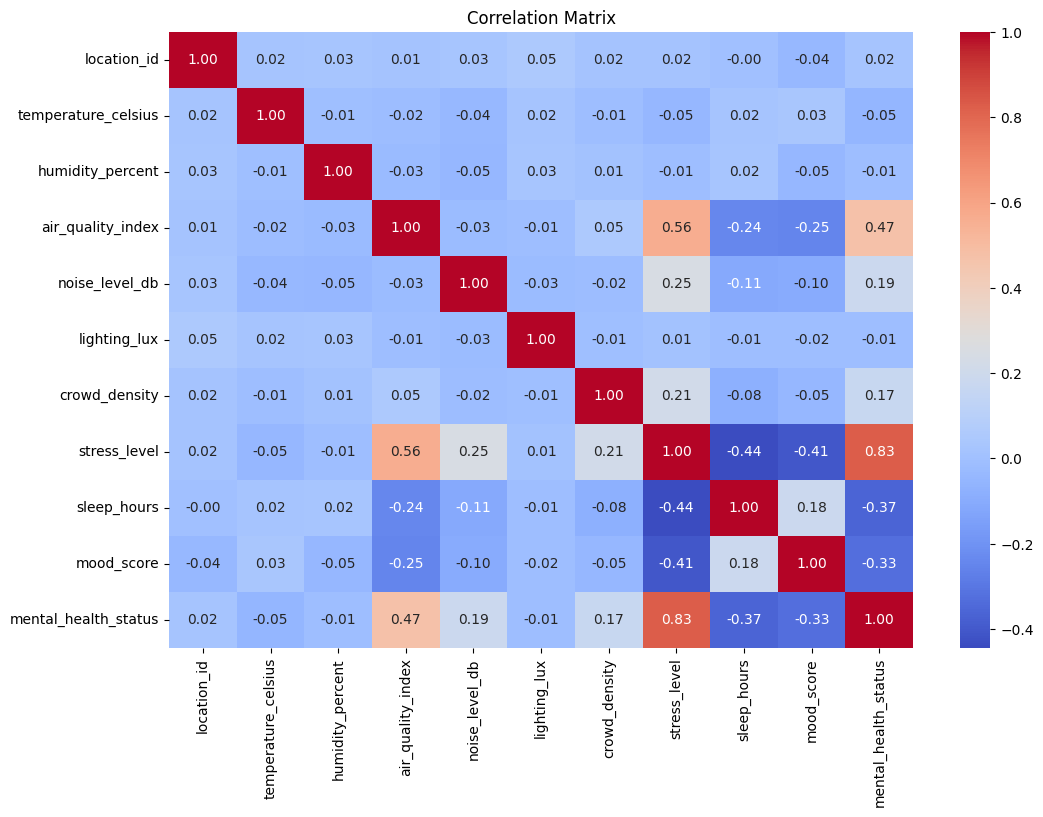

In [27]:
%matplotlib inline
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(numeric_only=True),annot=True,cmap="coolwarm",fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

Outlier count per numerical column:
temperature_celsius: 0
humidity_percent: 0
air_quality_index: 0
noise_level_db: 0
lighting_lux: 0
crowd_density: 0
stress_level: 0
sleep_hours: 0
mood_score: 0


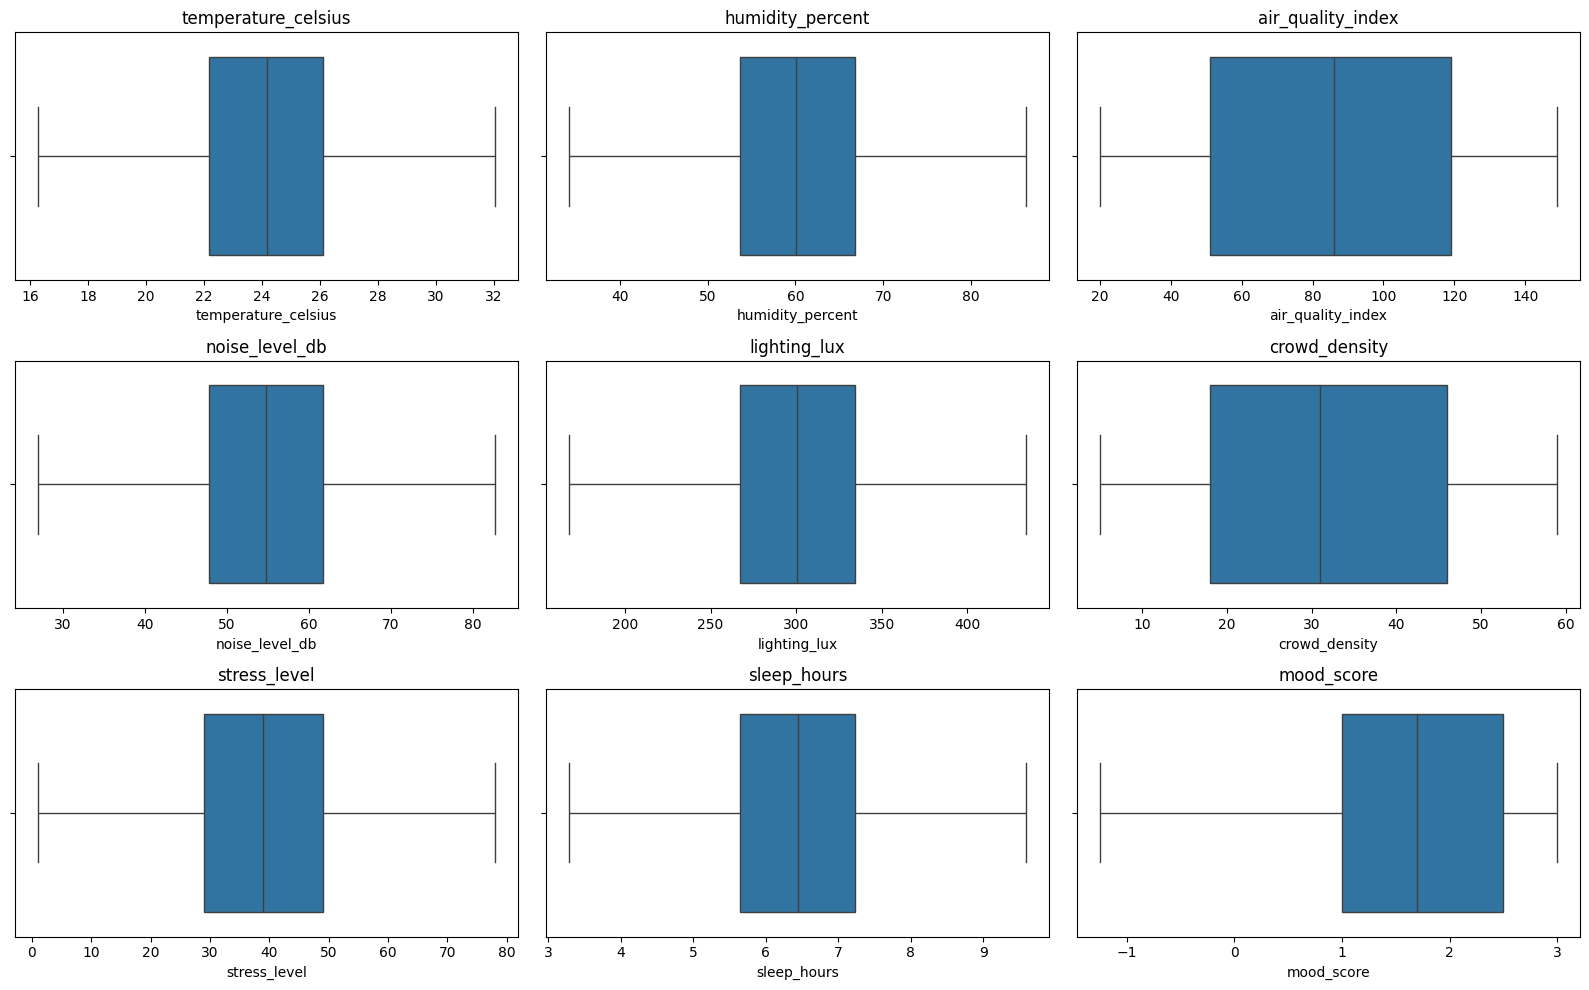

In [26]:
%matplotlib inline
numerical_cols = [
    'temperature_celsius', 'humidity_percent', 'air_quality_index',
    'noise_level_db', 'lighting_lux', 'crowd_density',
    'stress_level', 'sleep_hours', 'mood_score'
]


outlier_summary = {}

for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower) | (df[col] > upper)]
    outlier_summary[col] = len(outliers)


print("Outlier count per numerical column:")
for col, count in outlier_summary.items():
    print(f"{col}: {count}")

plt.figure(figsize=(16, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x=df[col])
    plt.title(col)
plt.tight_layout()
plt.show()

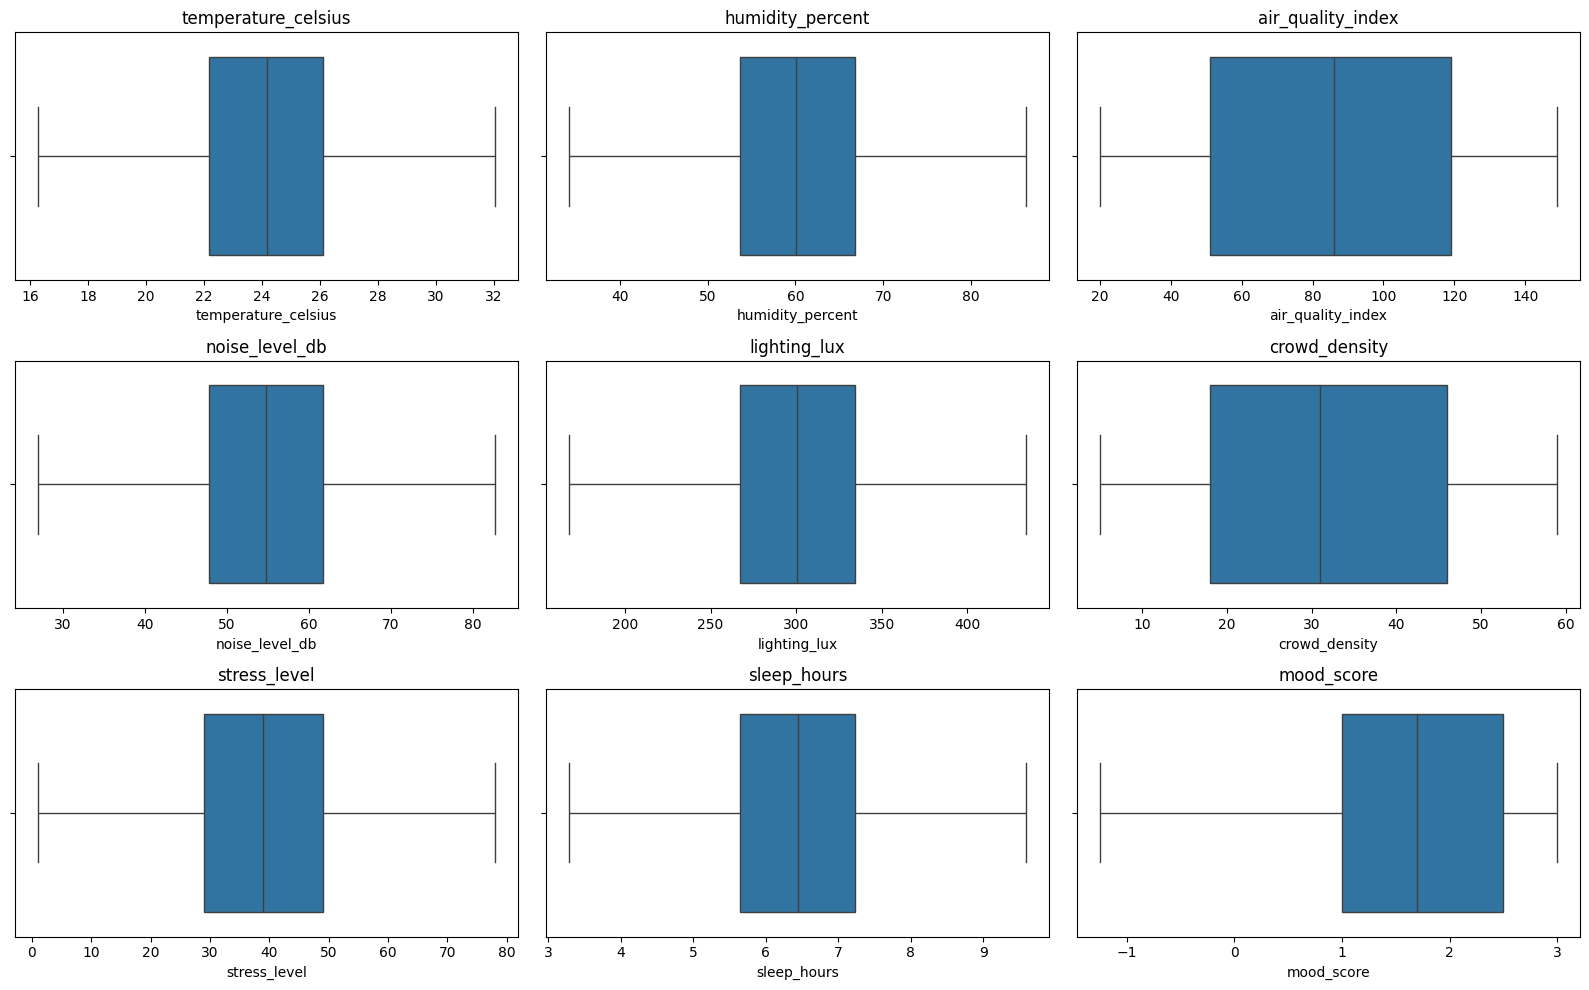

In [24]:
%matplotlib inline
for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df[col] = df[col].clip(lower, upper)

plt.figure(figsize=(16, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x=df[col])
    plt.title(col)
plt.tight_layout()
plt.show()


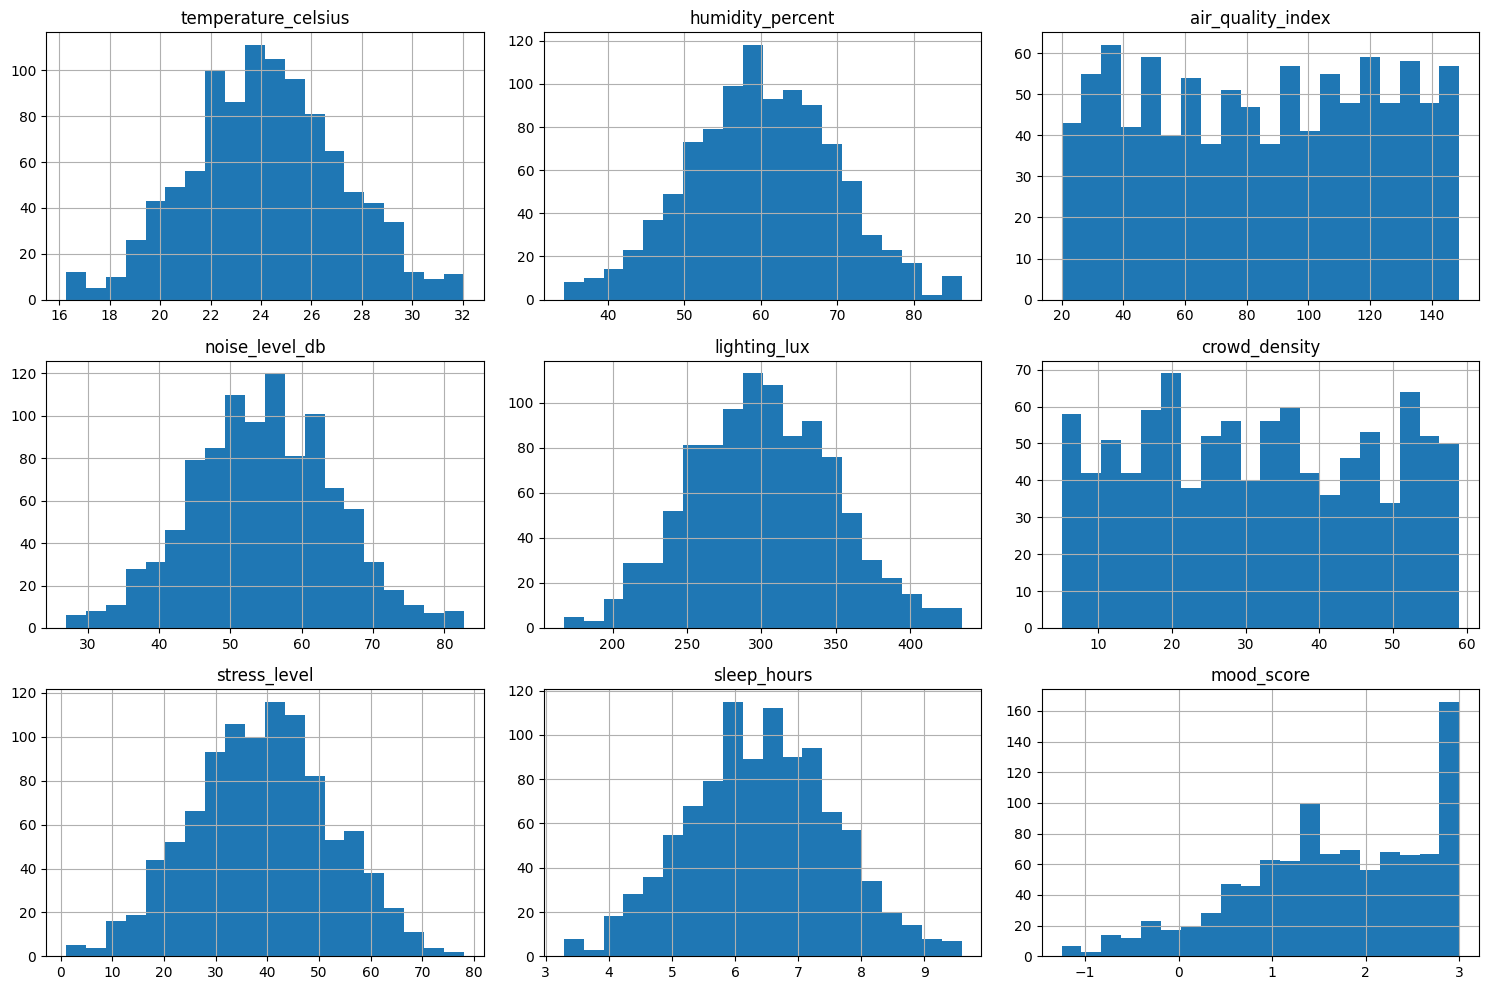

In [25]:
%matplotlib inline
df[numerical_cols].hist(bins=20, figsize=(15,10))
plt.tight_layout()
plt.show()

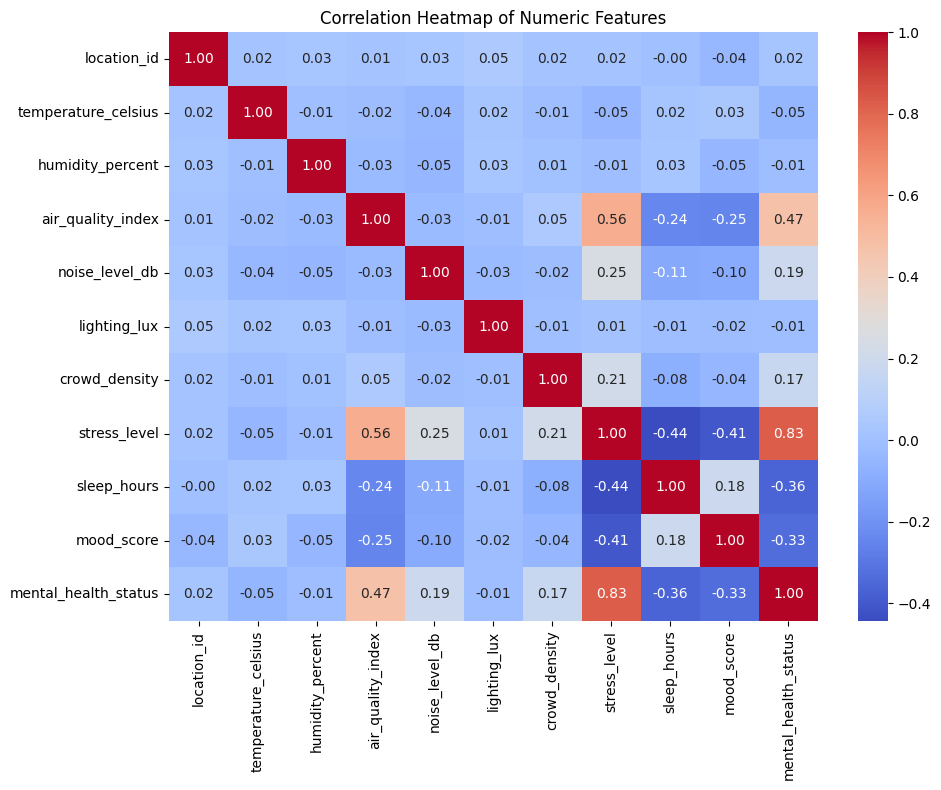

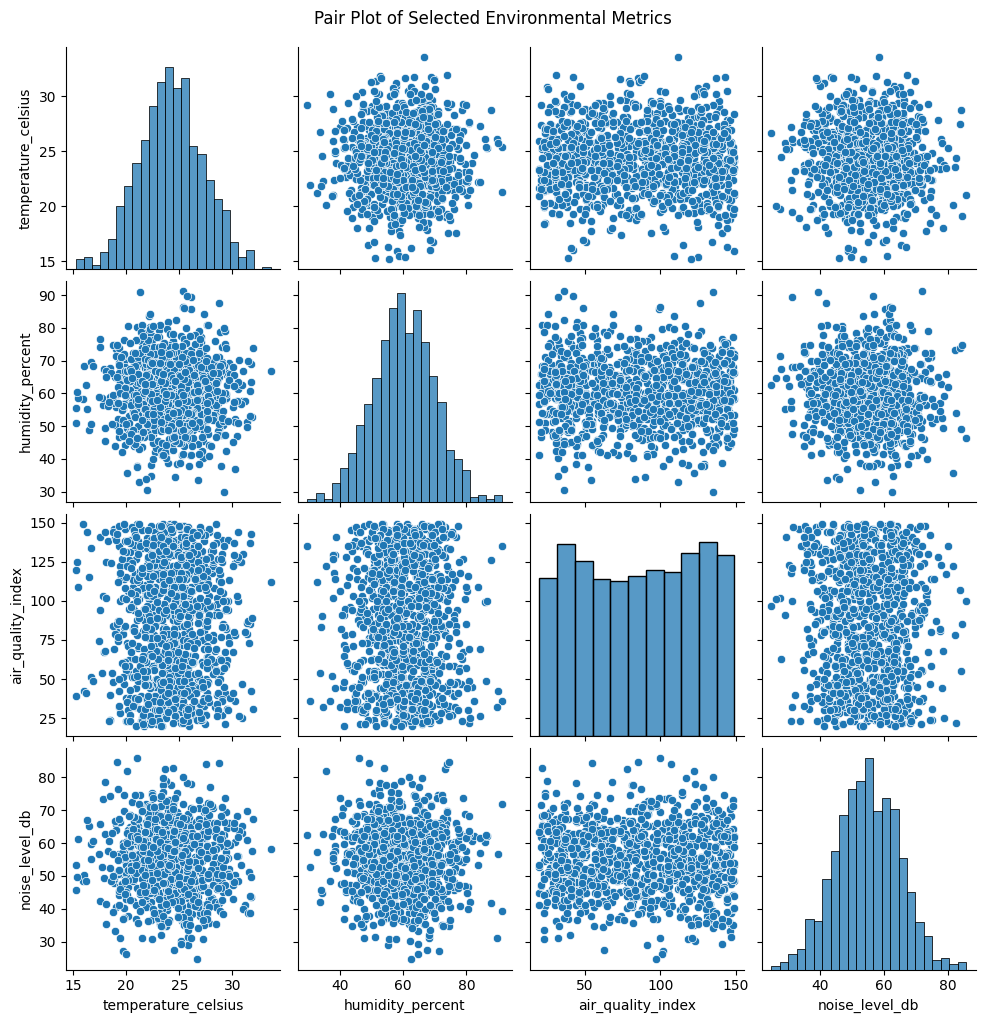

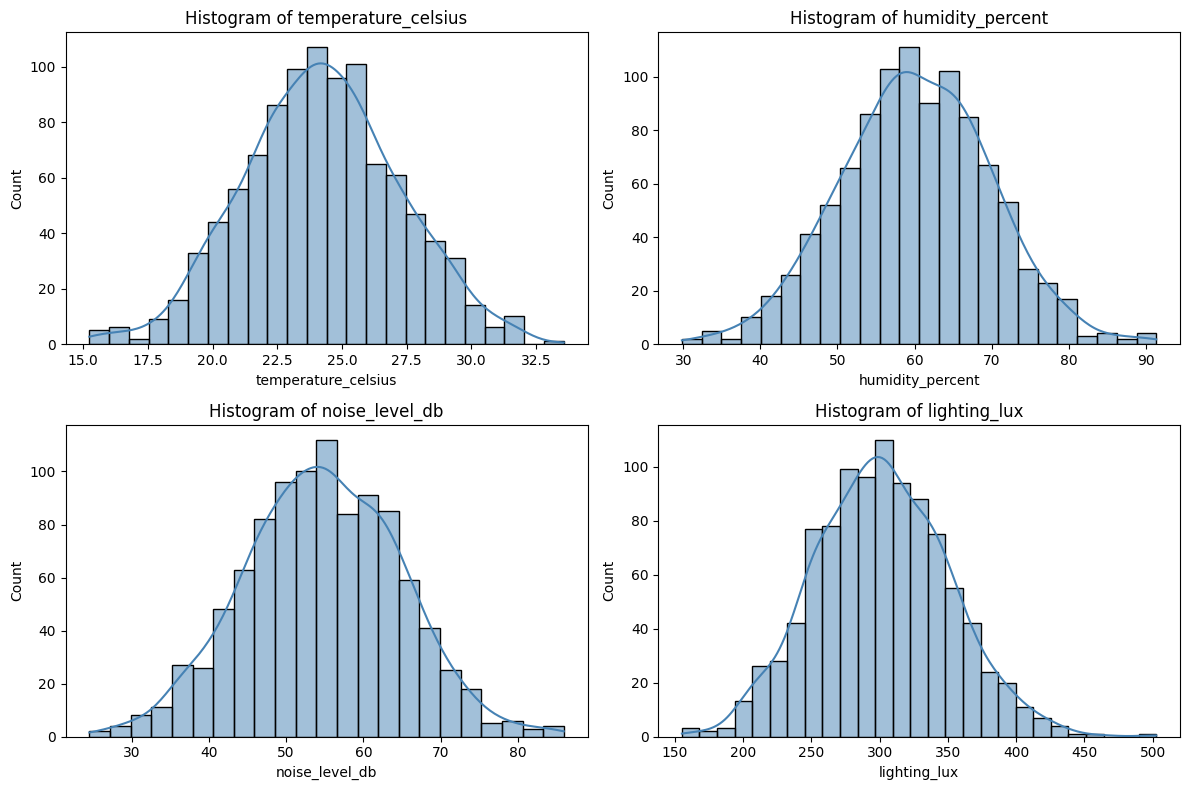

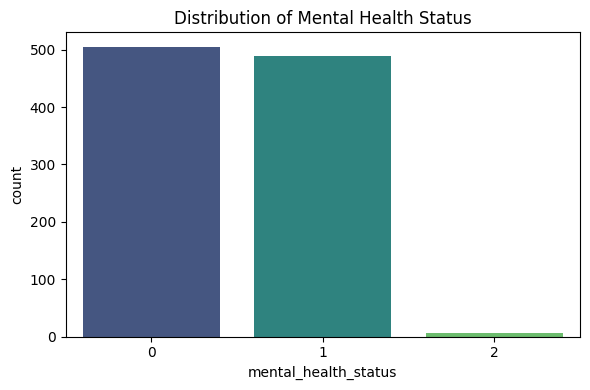

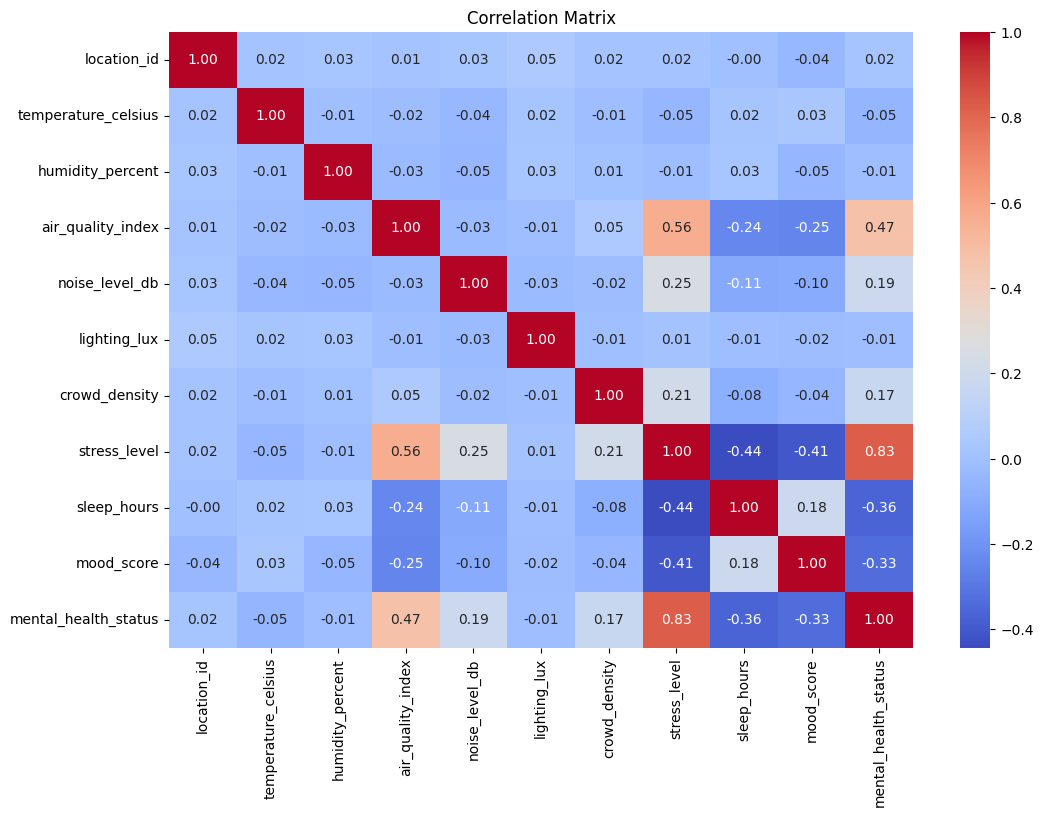

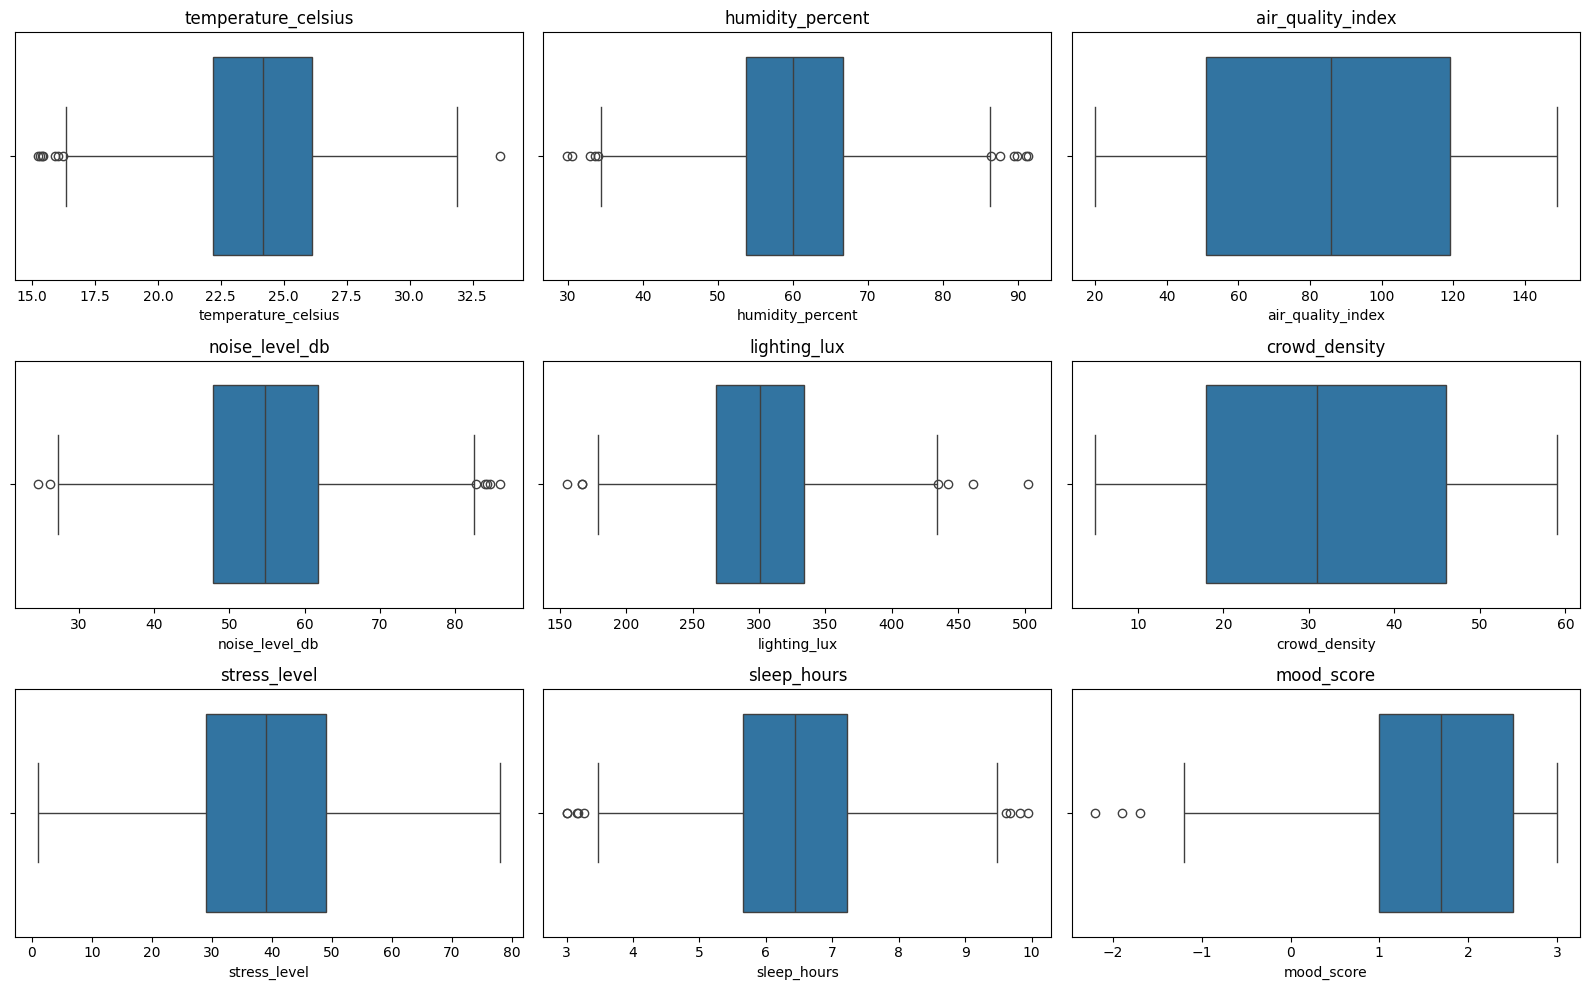

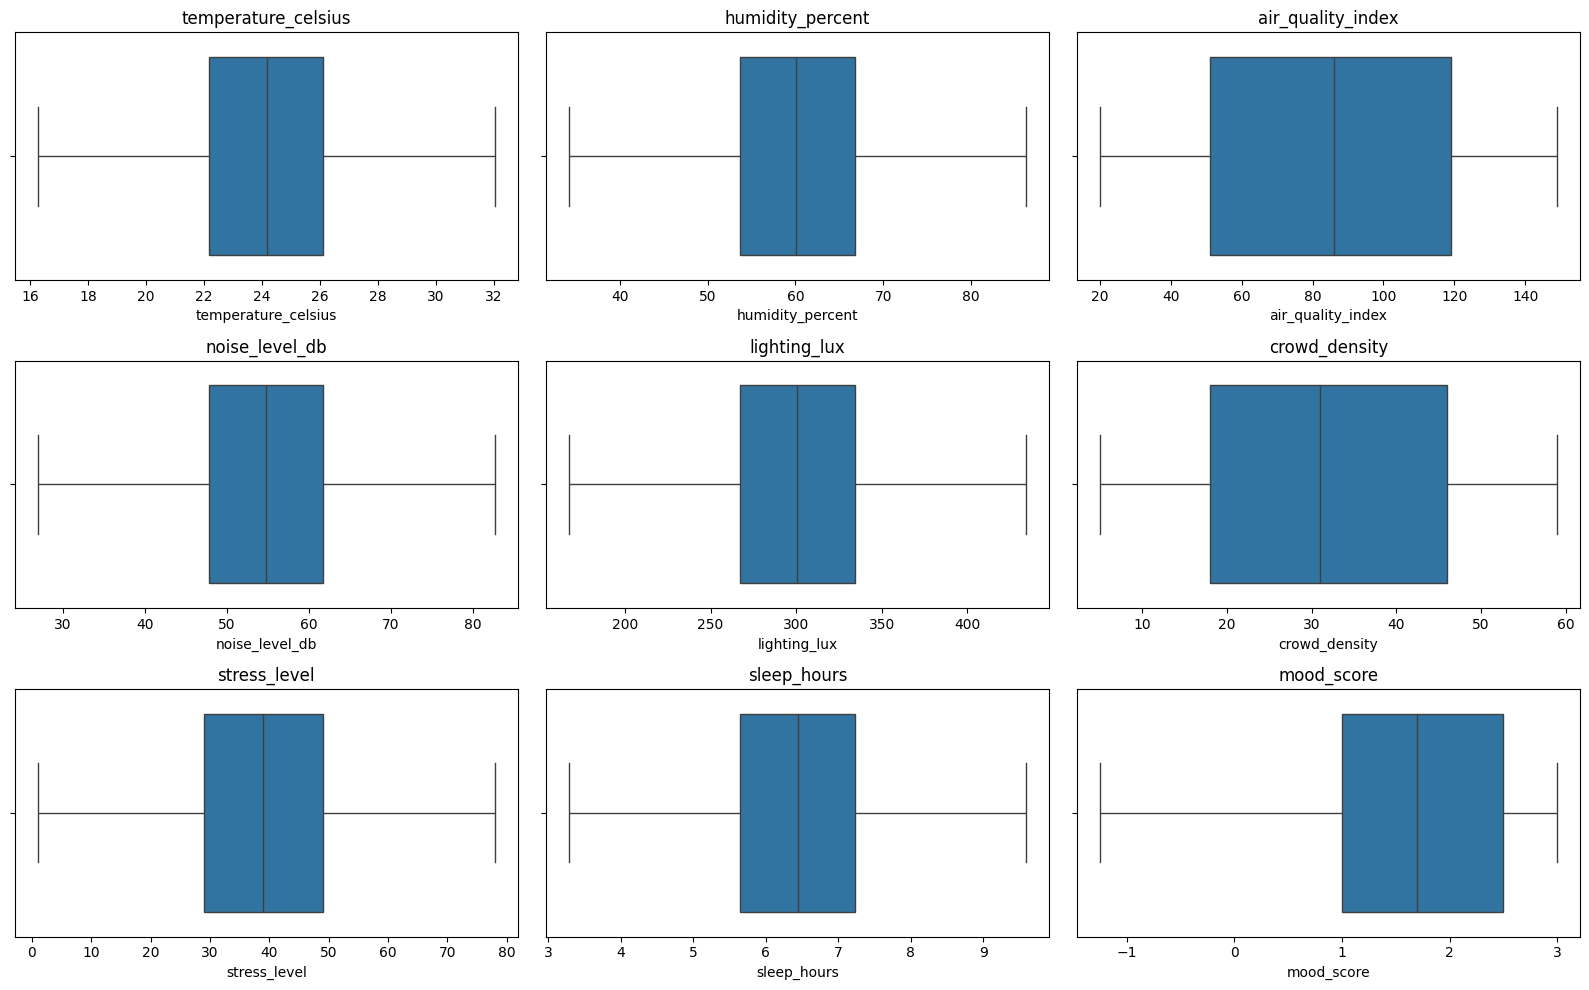

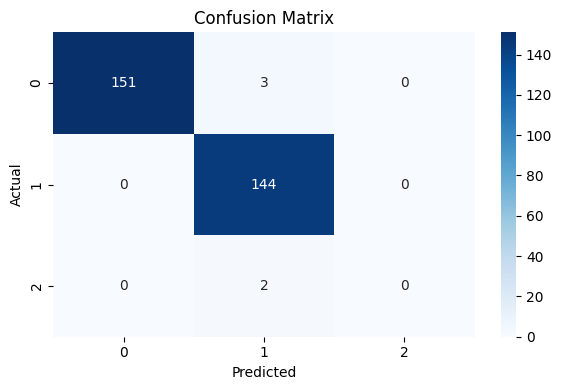

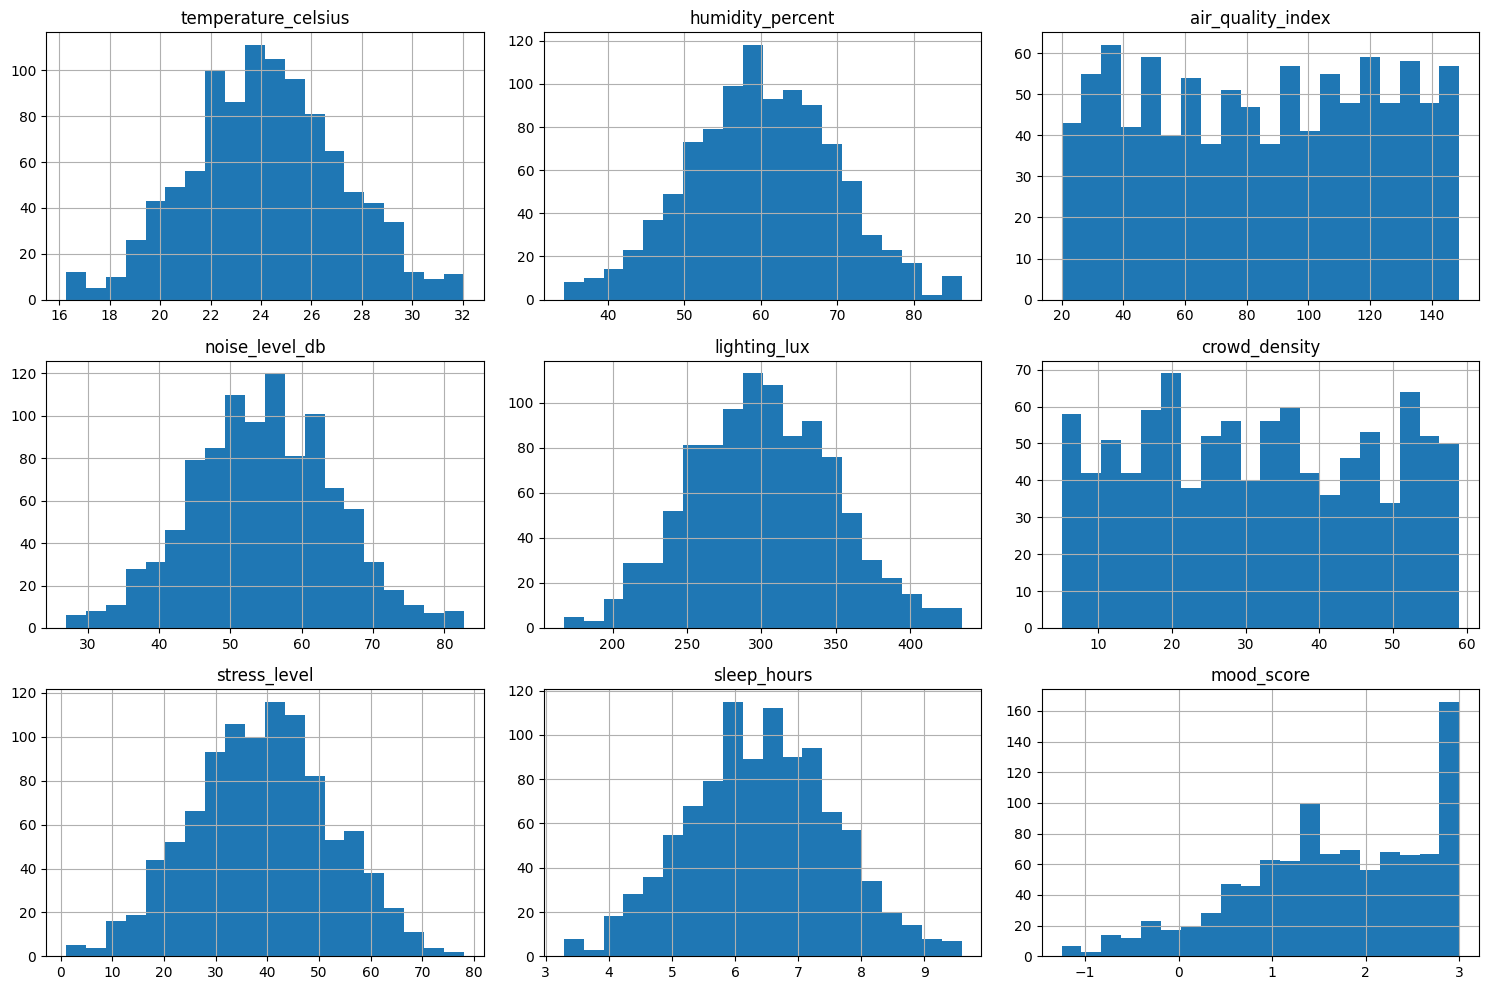

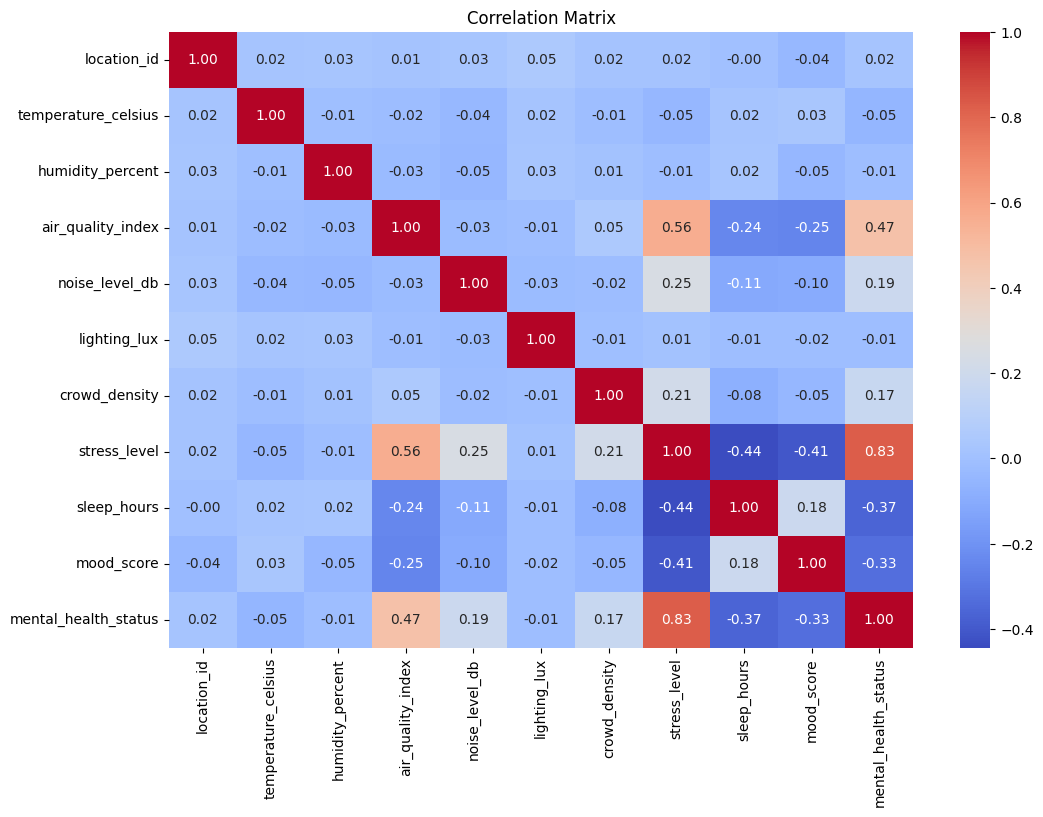

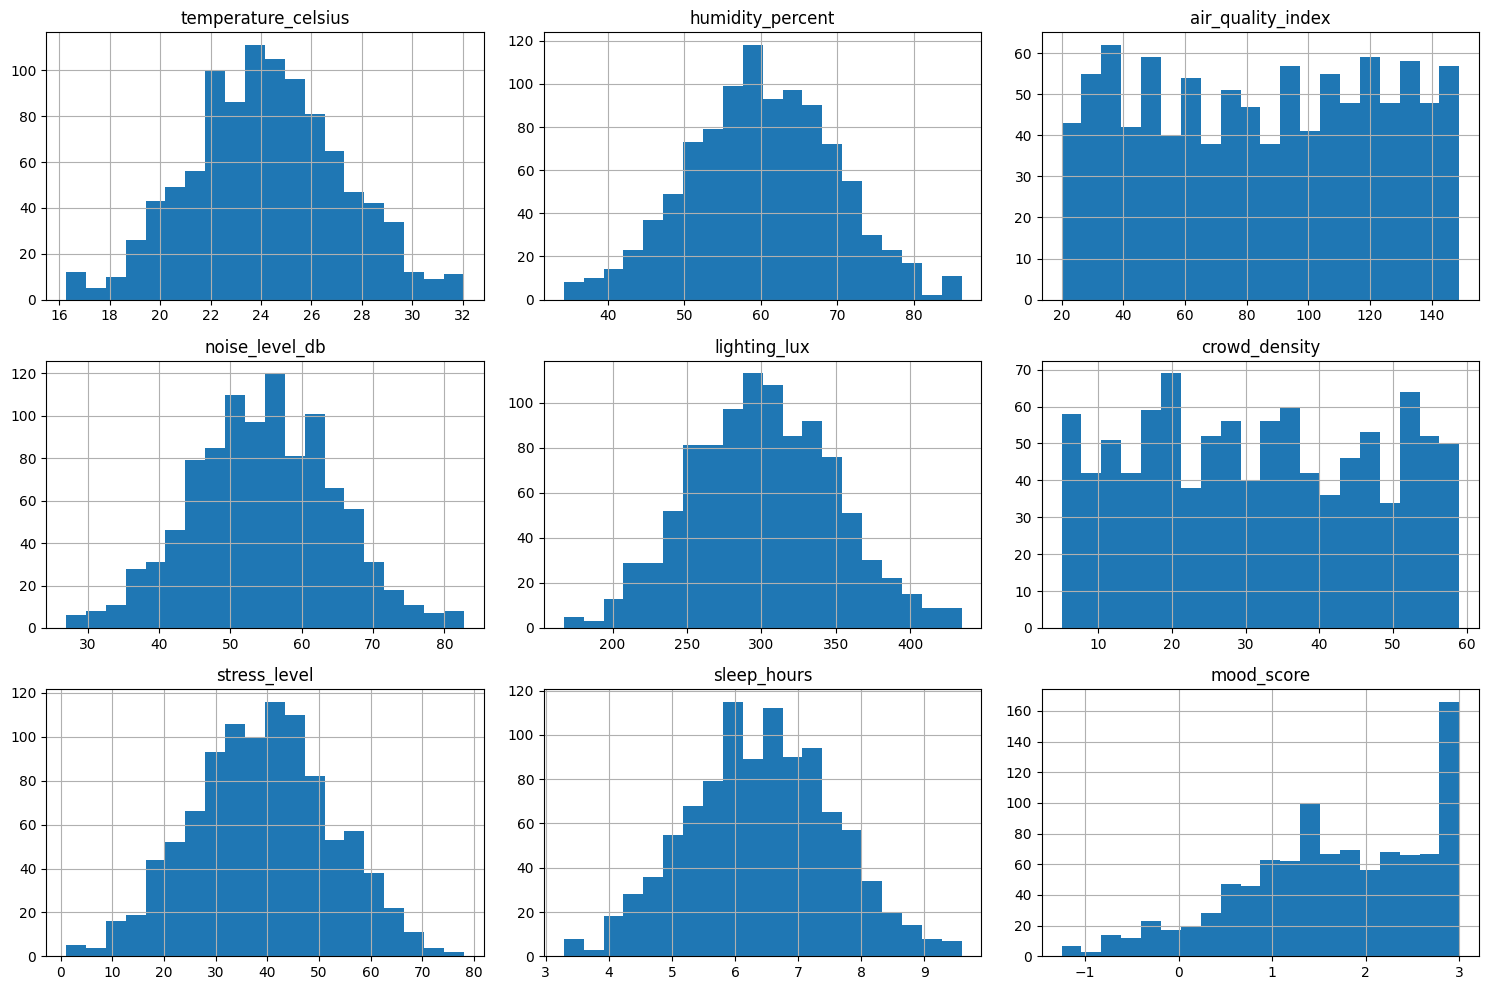

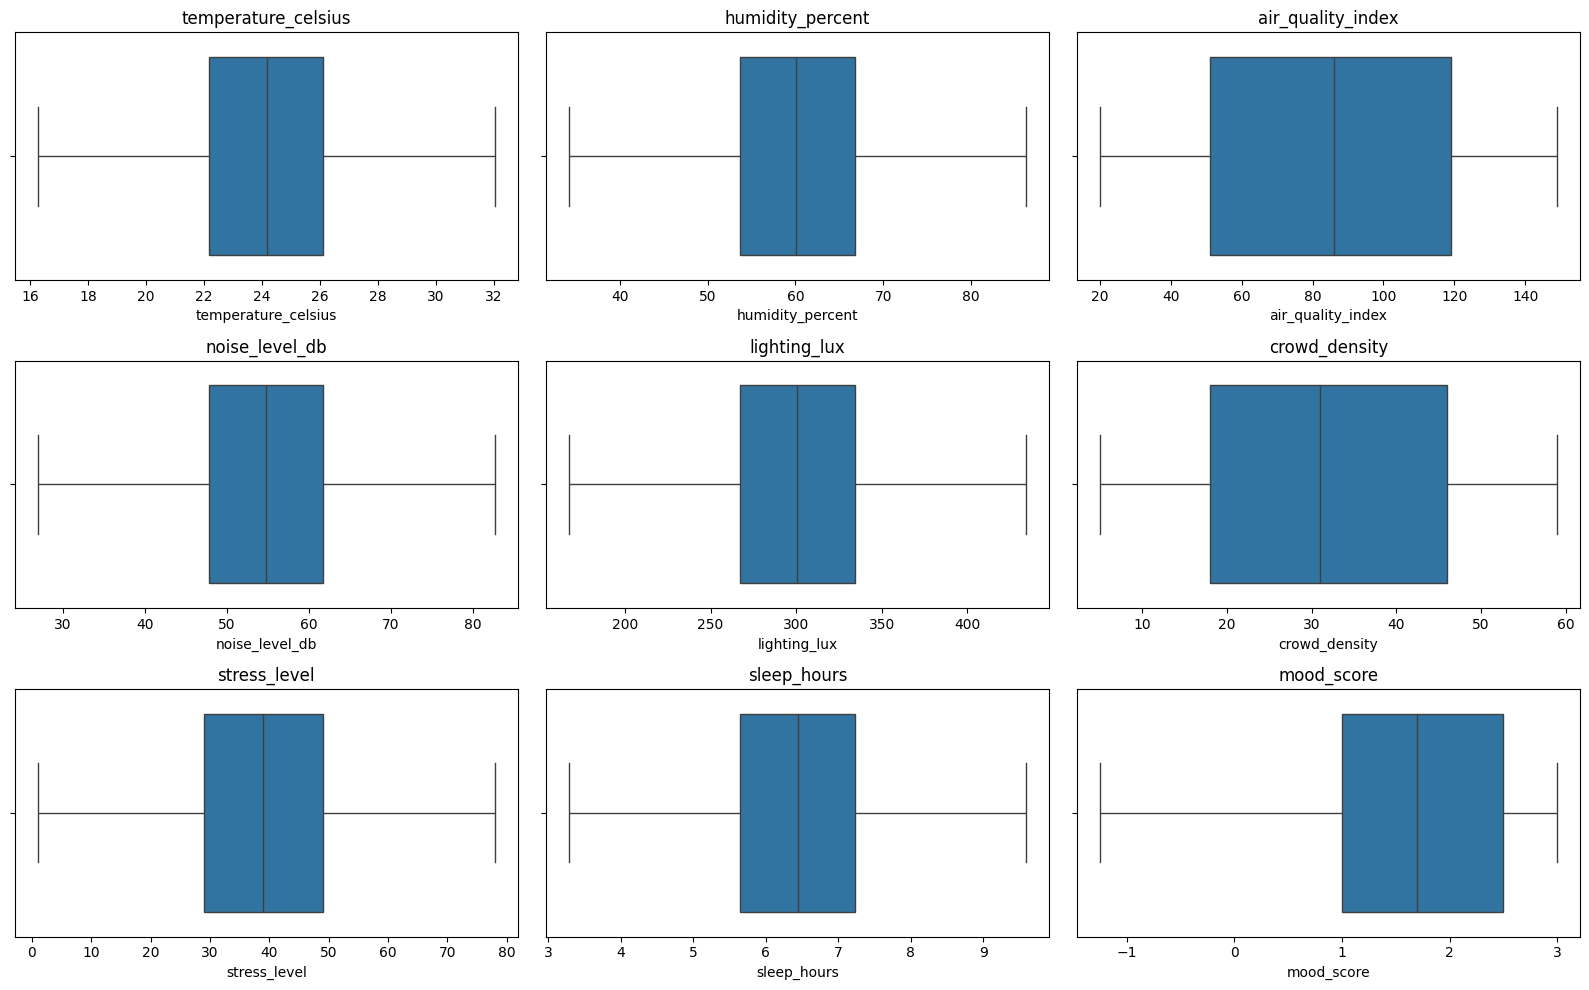

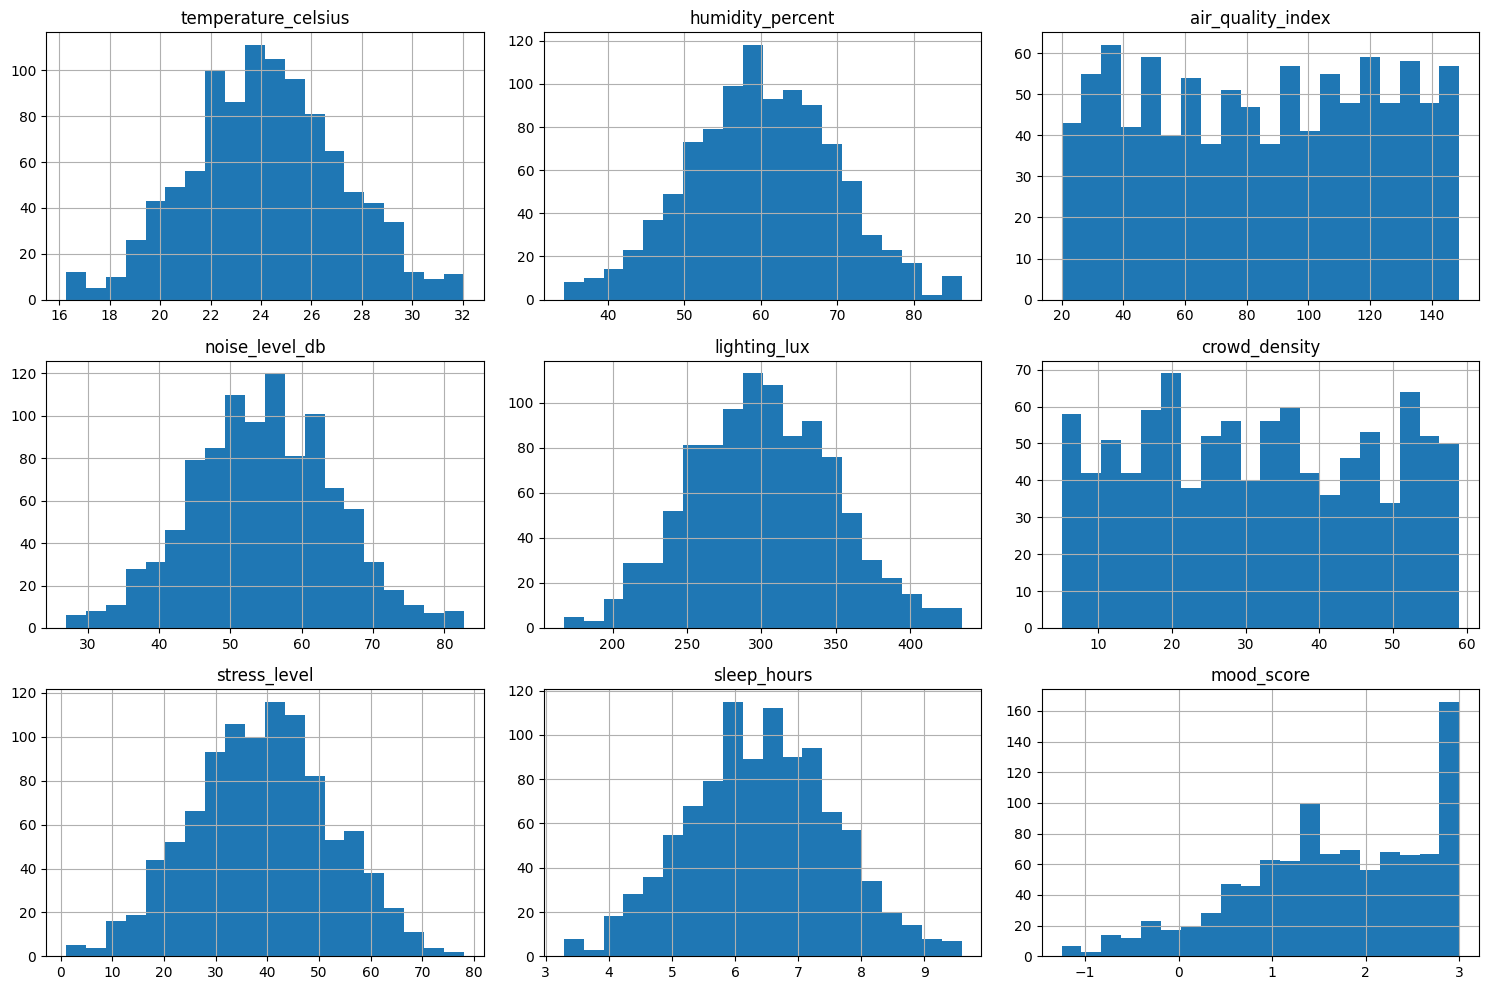

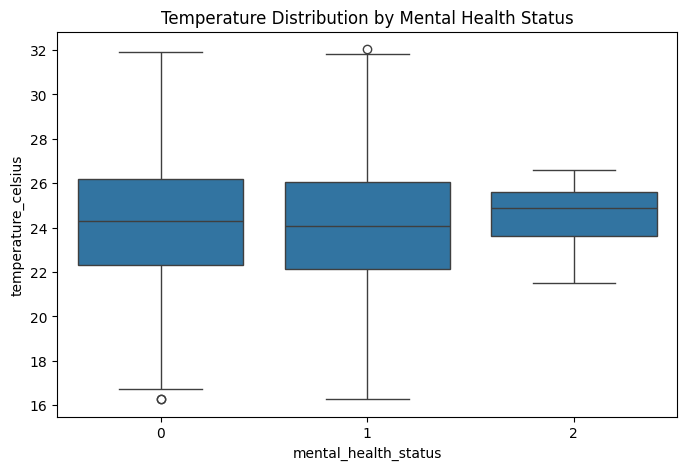

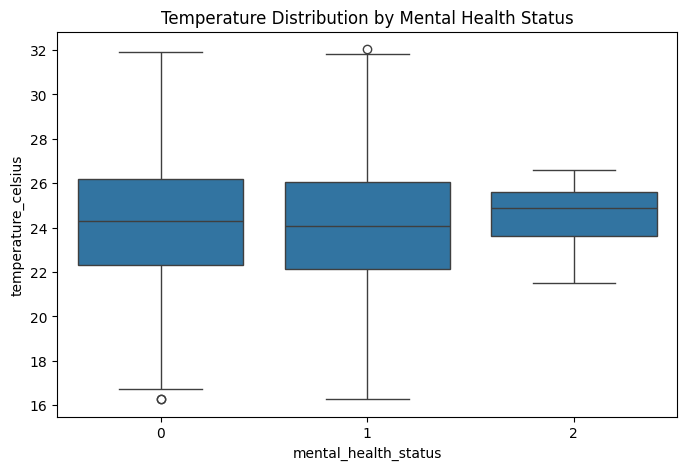

In [23]:
%matplotlib inline
plt.figure(figsize=(8,5))
sns.boxplot(x='mental_health_status', y='temperature_celsius', data=df)
plt.title('Temperature Distribution by Mental Health Status')
plt.show()

In [22]:
print(df['mental_health_status'].value_counts())

0    505
1    489
2      6
Name: mental_health_status, dtype: int64


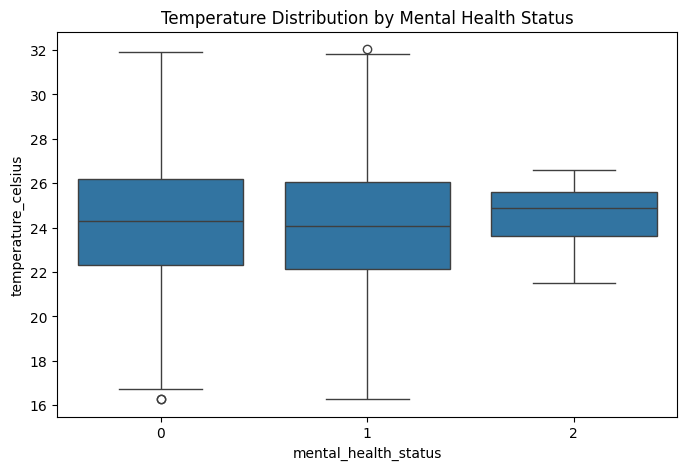

In [39]:
plt.figure(figsize=(8,5))
sns.boxplot(x='mental_health_status', y='temperature_celsius', data=df)
plt.title('Temperature Distribution by Mental Health Status')
plt.show()

In [29]:
df_filtered = df[df['mental_health_status'] != 2]

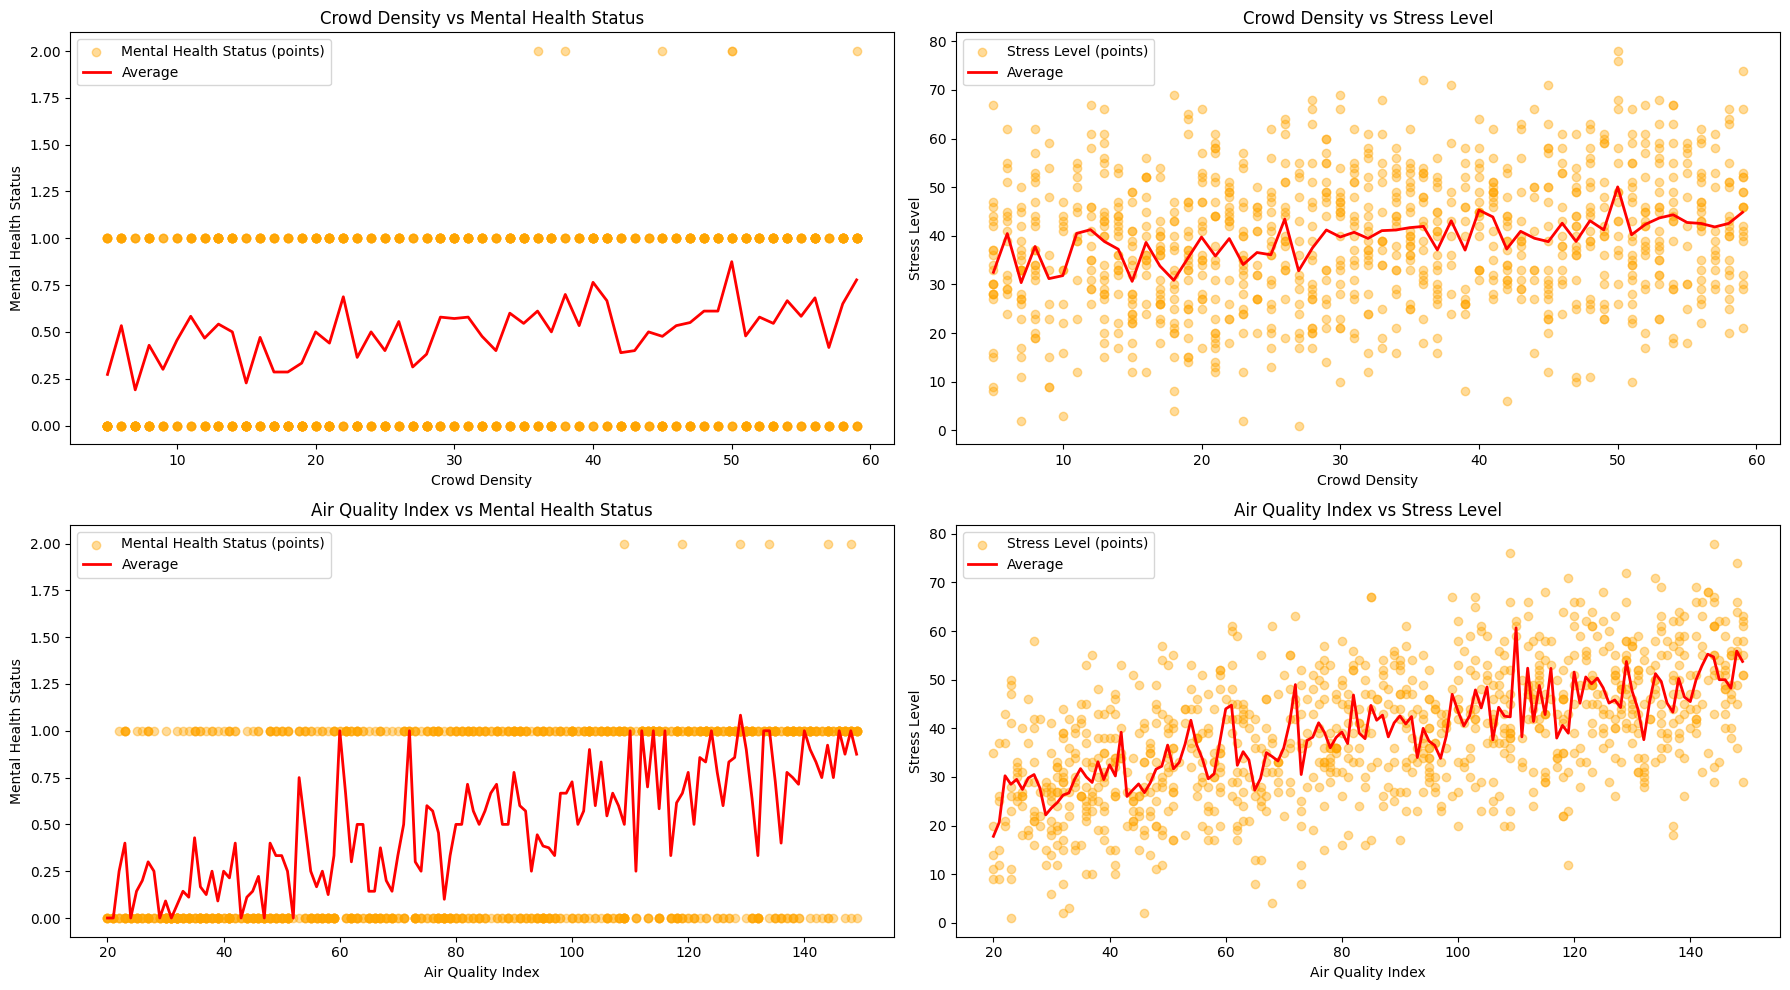

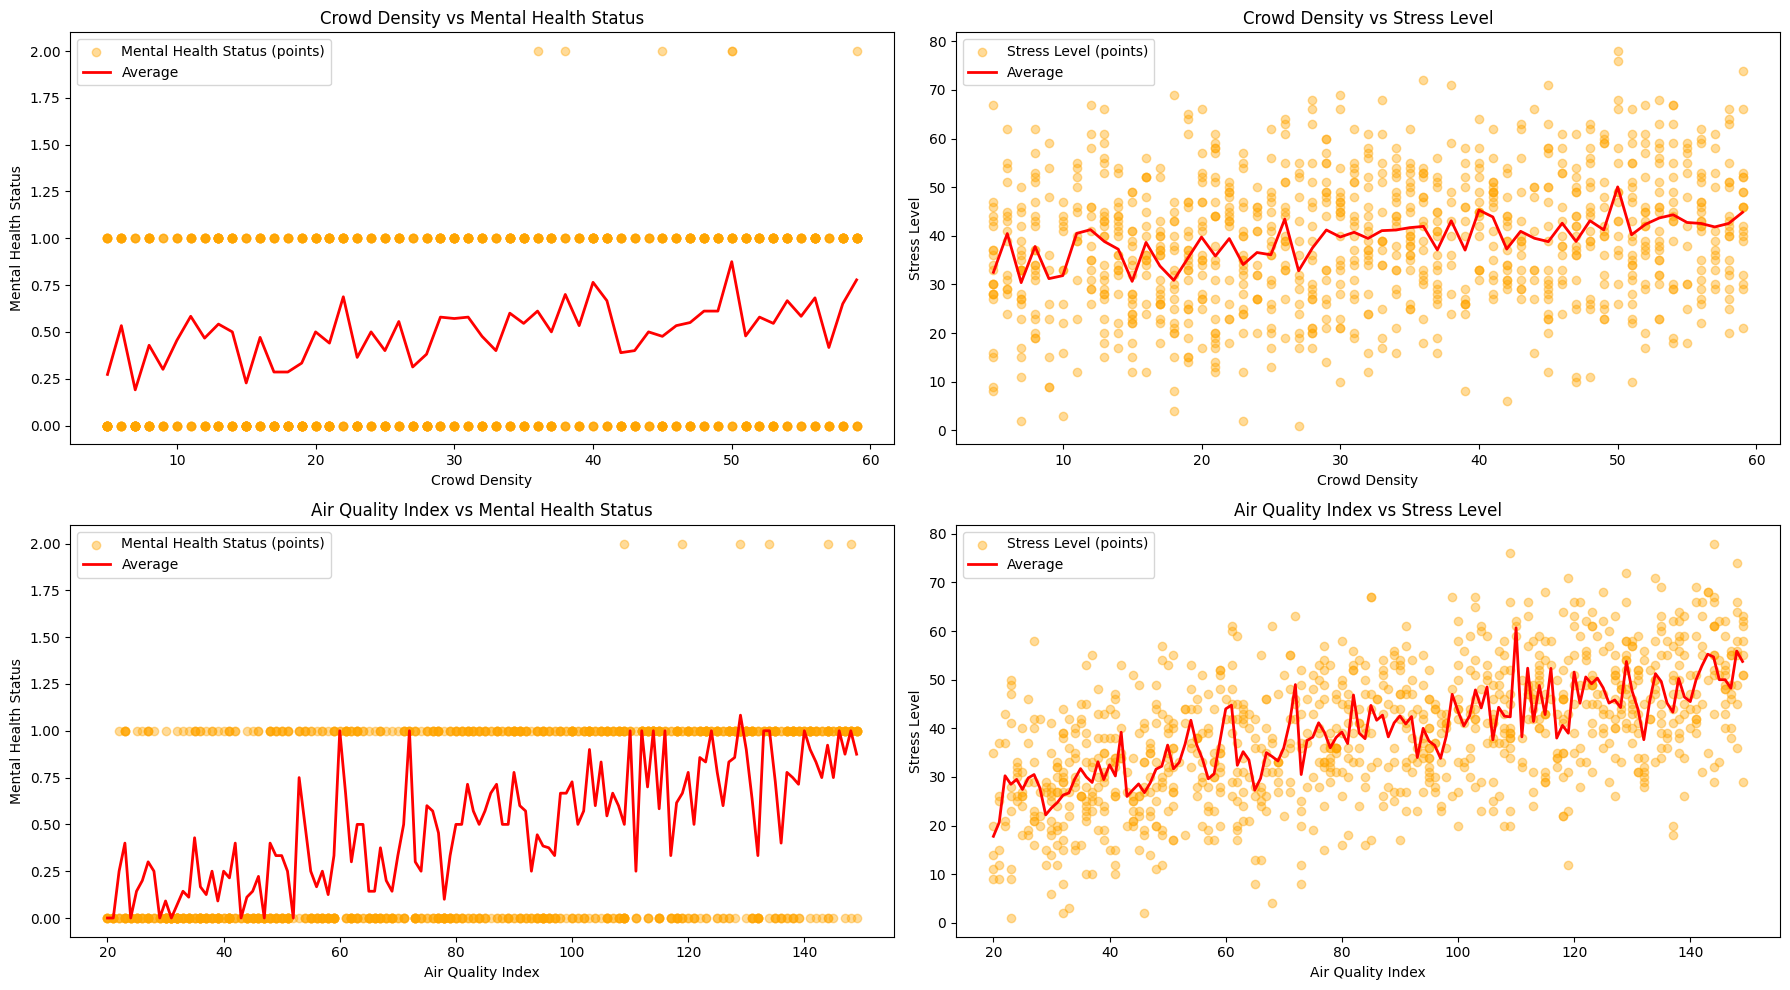

In [30]:
%matplotlib inline
cols = ["crowd_density", "air_quality_index"]
targets = ["mental_health_status", "stress_level"]

fig, axs = plt.subplots(2, 2, figsize=(18, 10))  
axs = axs.flatten()

plot_index = 0

for col in cols:
    for target in targets:
        ax = axs[plot_index]
        ax.scatter(df[col], df[target], alpha=0.4, label=f"{target.replace('_', ' ').title()} (points)", color="orange")
        mean = df.groupby(col)[target].mean()
        ax.plot(mean.index, mean.values, color="red", linewidth=2, label="Average")
        ax.set_xlabel(col.replace('_', ' ').title())
        ax.set_ylabel(target.replace('_', ' ').title())
        ax.set_title(f"{col.replace('_', ' ').title()} vs {target.replace('_', ' ').title()}")
        ax.legend()

        plot_index += 1

plt.tight_layout()
plt.show()

cols = ["crowd_density", "air_quality_index"]
targets = ["mental_health_status", "stress_level"]

fig, axs = plt.subplots(2, 2, figsize=(18, 10))  
axs = axs.flatten()

plot_index = 0

for col in cols:
    for target in targets:
        ax = axs[plot_index]
        ax.scatter(df[col], df[target], alpha=0.4, label=f"{target.replace('_', ' ').title()} (points)", color="orange")
        mean = df.groupby(col)[target].mean()
        ax.plot(mean.index, mean.values, color="red", linewidth=2, label="Average")
        ax.set_xlabel(col.replace('_', ' ').title())
        ax.set_ylabel(target.replace('_', ' ').title())
        ax.set_title(f"{col.replace('_', ' ').title()} vs {target.replace('_', ' ').title()}")
        ax.legend()

        plot_index += 1

plt.tight_layout()
plt.show()


# Model 

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [32]:
features = [col for col in numerical_cols if col != 'location_id']
X = df_filtered[features]
y = df_filtered['mental_health_status']

In [33]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [34]:
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [35]:
model=LogisticRegression(max_iter=1000)
model.fit(X_train_scaled,y_train)

LogisticRegression(max_iter=1000)

In [36]:
y_pred=model.predict(X_test_scaled)

In [37]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9849246231155779

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.98        99
           1       0.97      1.00      0.99       100

    accuracy                           0.98       199
   macro avg       0.99      0.98      0.98       199
weighted avg       0.99      0.98      0.98       199



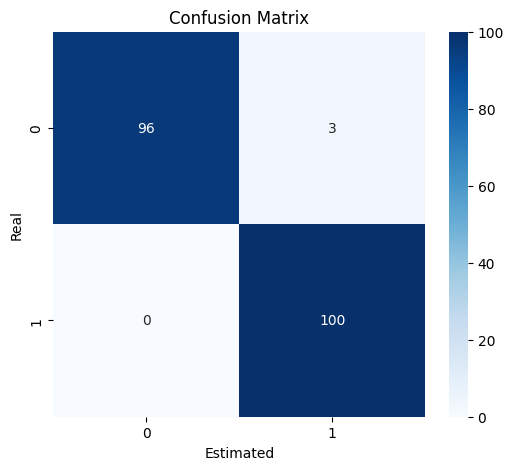

In [38]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Estimated')
plt.ylabel('Real')
plt.title('Confusion Matrix')
plt.show()